In [ ]:
# instalar catboost (Colab-google)
# biblioteca externa
!pip install catboost

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=4. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:34:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Melhor configuração: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=4. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 24618, number of used features: 7
[LightGBM] [Info] Start training from score -1.619768
[LightGBM] [Info] Start training from score -1.594840
[LightGBM] [Info] Start training from score -1.615877
[LightGBM] [Info] Start training from score -1.604899
[LightGBM] [Info] Start training from score -1.612000
LightGBM - Melhor configuração: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=4. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CatBoost - Melhor configuração: {'learning_rate': 0.1, 'iterations': 200, 'depth': 10}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 24618, number of used features: 7
[LightGBM] [Info] Start training from score -1.619768
[LightGBM] [Info] Start training from score -1.594840
[LightGBM] [Info] Start training from score -1.615877
[LightGBM] [Info] Start training from score -1.604899
[LightGBM] [Info] Start training from score -1.612000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:39:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Modelo salvo com sucesso!


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Voting Classifier:
Acurácia: 0.9674628320740921
AUC-ROC: 0.9988781893845425
F1-Score: 0.9674284946137722
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      4873
           1       0.97      0.97      0.97      4996
           2       0.97      0.97      0.97      4892
           3       0.97      0.98      0.98      4946
           4       0.97      0.97      0.97      4911

    accuracy                           0.97     24618
   macro avg       0.97      0.97      0.97     24618
weighted avg       0.97      0.97      0.97     24618



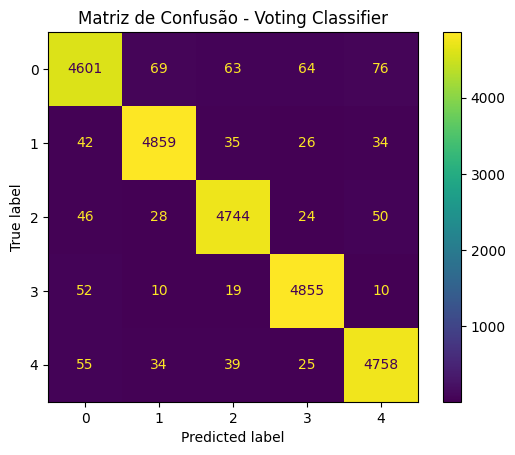

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Carregar os dados
dados = pd.read_csv("treino.csv")
dados = dados.drop(columns=["id"])  # Removendo ID para treinamento

dados.columns = [
    "TempMédia", "Gravidade", "PressãoAtm", "Radiação", "ComposiçãoAr", "Hidratação",
    "Vegetação", "Fauna", "SoloFértil", "Ventos", "Luas", "Magnetismo", "ClimaEstável", "target"
]

# Criar novas features
def criar_features(df):
    df["TempPressão"] = df["TempMédia"] * df["PressãoAtm"]
    df["GravidadeRadiação"] = df["Gravidade"] * df["Radiação"]
    df["MédiaSoloVegetação"] = (df["SoloFértil"] + df["Vegetação"]) / 2
    df["InteraçãoFaunaClima"] = df["Fauna"] * df["ClimaEstável"]
    df["InteraçãoMagnetismoGravidade"] = df["Magnetismo"] * df["Gravidade"]

    # Clusterização para capturar padrões ocultos
    kmeans = KMeans(n_clusters=5, random_state=42)
    df['Cluster'] = kmeans.fit_predict(df.drop(columns=["target"]))

    return df

dados = criar_features(dados)

# Tratamento de outliers
from scipy.stats import zscore
z_scores = np.abs(zscore(dados.drop(columns=["target"])))
dados = dados[(z_scores < 3).all(axis=1)]

# Balanceamento de classes
X = dados.drop(columns=['target'])
y = dados['target']
adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X, y)

# Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

# Redução de dimensionalidade
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Cross-validation estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelos e hiperparâmetros
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

tuned_params = {
    "XGBoost": {'n_estimators': [200], 'max_depth': [10], 'learning_rate': [0.2]},
    "LightGBM": {'n_estimators': [200], 'max_depth': [10], 'learning_rate': [0.1]},
    "CatBoost": {'iterations': [200], 'depth': [10], 'learning_rate': [0.1]}
}

best_models = {}
for name, model in models.items():
    search = RandomizedSearchCV(model, tuned_params[name], n_iter=4, cv=cv, scoring='f1_weighted', random_state=42, n_jobs=-1)
    search.fit(X_pca, y_res)
    best_models[name] = search.best_estimator_
    print(f"{name} - Melhor configuração: {search.best_params_}")

# Criar Voting Classifier
eclf = VotingClassifier(
    estimators=[
        ("LightGBM", best_models["LightGBM"]),
        ("CatBoost", best_models["CatBoost"]),
        ("XGBoost", best_models["XGBoost"])
    ],
    voting="soft",
    weights=[2, 3, 1]  # Ajuste do peso do CatBoost
)

eclf.fit(X_pca, y_res)

# Salvar o modelo treinado
joblib.dump(eclf, "modelo_voting.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")

print("\nModelo salvo com sucesso!")

# Avaliação do modelo
y_pred = eclf.predict(X_pca)
y_pred_proba = eclf.predict_proba(X_pca)

print("\nVoting Classifier:")
print("Acurácia:", accuracy_score(y_res, y_pred))
print("AUC-ROC:", roc_auc_score(y_res, y_pred_proba, multi_class='ovr'))
print("F1-Score:", f1_score(y_res, y_pred, average='weighted'))
print(classification_report(y_res, y_pred))
cm = confusion_matrix(y_res, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Matriz de Confusão - Voting Classifier")
plt.show()


Script com a saída dos resultados em csv

In [11]:

# Carregar modelo, scaler e PCA
eclf = joblib.load("modelo_voting.pkl")
scaler = joblib.load("scaler.pkl")
pca = joblib.load("pca.pkl")

# Carregar a base de teste
teste = pd.read_csv("teste.csv")

# Salvar o ID para o arquivo final
ids = teste["id"]

# Remover a coluna ID para predição
teste = teste.drop(columns=["id"])

teste.columns = [
    "TempMédia", "Gravidade", "PressãoAtm", "Radiação", "ComposiçãoAr", "Hidratação",
    "Vegetação", "Fauna", "SoloFértil", "Ventos", "Luas", "Magnetismo", "ClimaEstável"
]

# Aplicar as mesmas features engineering usadas no treino
def criar_features(df):
    df["TempPressão"] = df["TempMédia"] * df["PressãoAtm"]
    df["GravidadeRadiação"] = df["Gravidade"] * df["Radiação"]
    df["MédiaSoloVegetação"] = (df["SoloFértil"] + df["Vegetação"]) / 2
    df["InteraçãoFaunaClima"] = df["Fauna"] * df["ClimaEstável"]
    df["InteraçãoMagnetismoGravidade"] = df["Magnetismo"] * df["Gravidade"]

    # Cluster foi gerado no treino, precisamos recriá-lo aqui:
    df["Cluster"] = (df["Gravidade"] * df["Radiação"] + df["Fauna"] * df["SoloFértil"]).round(1)

    return df


teste = criar_features(teste)

# Padronizar os dados
X_scaled = scaler.transform(teste)

# Aplicar a redução de dimensionalidade com PCA
X_pca = pca.transform(X_scaled)

# Realizar a predição
y_pred = eclf.predict(X_pca)

# Criar o DataFrame final
resultado = pd.DataFrame({
    "id": ids,
    "target": y_pred
})

# Salvar o arquivo CSV
resultado.to_csv("ultimate.csv", index=False)

print("Arquivo de predição salvo com sucesso: ultimate.csv")



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Arquivo de predição salvo com sucesso: ultimate.csv
